# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: Xavier and Kaiming initializations
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\U7W20E6\AppData\Local\Temp/ipykernel_25660/11644061.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create the DL model

In [2]:
# create a class for the model
class thenet(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(100,100)
    
    ### hidden layer
    self.fc1 = nn.Linear(100,100)
    self.fc2 = nn.Linear(100,100)
    self.fc3 = nn.Linear(100,100)

    ### output layer
    self.output = nn.Linear(100,2)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    x = F.relu( self.fc3(x) )
    return self.output(x)

# Explore the initialized weights

In [3]:
# create an instance of the model
net = thenet()
print(net)

thenet(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


There are 402 bias parameters.
There are 40200 weight parameters.


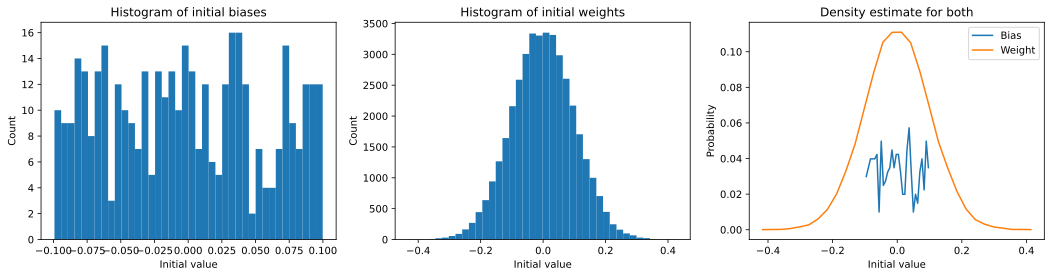

In [12]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
  if 'bias' in p[0]:
    allbiases = np.concatenate( (allbiases,p[1].data.numpy().flatten()),axis=0 )
  elif 'weight' in p[0]:
    allweight = np.concatenate( (allweight,p[1].data.numpy().flatten()),axis=0 )


# how many are there?
print(f'There are {len(allbiases)} bias parameters.')
print(f'There are {len(allweight)} weight parameters.')


# show their histograms
fig,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].hist(allbiases,40)
ax[0].set_title('Histogram of initial biases')


ax[1].hist(allweight,40)
ax[1].set_title('Histogram of initial weights')



# collect histogram data to show as line plots
yB,xB = np.histogram(allbiases,30)
yW,xW = np.histogram(allweight,30)

ax[2].plot((xB[1:]+xB[:-1])/2,yB/np.sum(yB),label='Bias')
ax[2].plot((xW[1:]+xW[:-1])/2,yW/np.sum(yW),label='Weight')
ax[2].set_title('Density estimate for both')
ax[2].legend()


# plot adjustments common to all subplots
for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')

plt.show()

# Layer-specific distributions

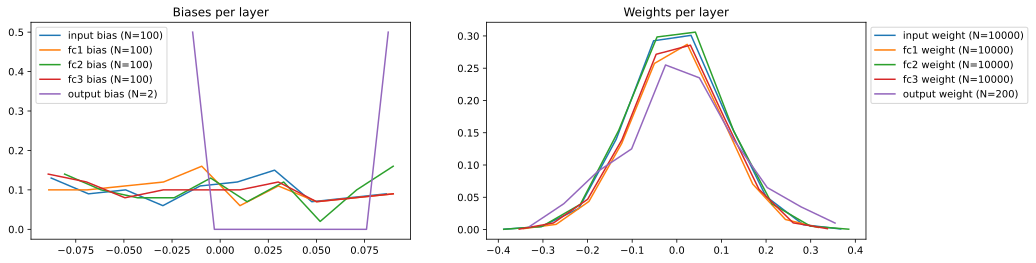

In [13]:

fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():

  # get the data and compute their histogram
  thesedata = p[1].data.numpy().flatten()
  y,x = np.histogram(thesedata,10)

  # for the bias
  if 'bias' in p[0]:
    ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

  # for the weights
  elif 'weight' in p[0]:
    ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))



ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [6]:
# What's up with the weird output bias distribution??
print( net.output.bias.data )

tensor([0.0717, 0.0196])


In [7]:
# Check out the docstring for linear layers
nn.Linear?

Init signature:
nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(*, H_{in})` where :math:`*` means any number of
      dimensions including none and :math:`H_{in} = \text{in\_features}`.
    - Output: :math:`(*, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(\text{out\_features}, \text{in\_features})`. The values are
        initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, wh

In [8]:
# Let's test whether the numbers match our prediction from the formula

# empirical bias range
biasrange = [ torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item() ]
biascount = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/biascount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma))
print('Empirical range = ' + str(biasrange))

Theoretical sigma = 0.1
Empirical range = [-0.09916903078556061, 0.09962791949510574]


# Now to initialize the weights using the Xavier method

In [17]:
# create a new instance of the model
net = thenet()

# change the weights (leave biases as Kaiming [default])
for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)

In [18]:
# Note: it is unconventional to have Kaiming biases and Xavier weights.
# Scroll up and re-run the previous weights visualization cells with the new network.
# Then continue below.

In [19]:
# Let's test whether the numbers match our prediction from the formula

# empirical weight standard deviation
weightvar   = torch.var(net.fc1.weight.data.flatten()).item()
weightcount = len(net.fc1.weight.data)

# theoretical expected value
sigma2 = 2 / (weightcount+weightcount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma2))
print('Empirical variance = ' + str(weightvar))

Theoretical sigma = 0.01
Empirical variance = 0.010013613849878311


In [20]:
# Note: There are several other weights initialization methods availabe in PyTorch.
#       See https://pytorch.org/docs/stable/nn.init.html

# Additional explorations

In [ ]:
# 1) Explore the weight initialization options using PyTorch's functions (nn.init.<method>). 
#    For example: apply Xavier-uniform, Kaiming, constant (this is what we did in the first video of this section).
# 